# Project 3 : NumPy, matplotlib, and Python functions

## Instructions

### Description

Below is a guided exercise in doing linear regression using a gradient descent algorithm.  The goal here isn't to teach you the gradient descent algorithm, or scientific computing in general, but to give you experience with using NumPy for matrix-vector math, matplotlib for simple visualizations, and more Python (specifically, writing functions).

### Grading

For grading purposes, we will clear all outputs from all your cells and then run them all from the top.  Please test your notebook in the same fashion before turning it in.

### Submitting Your Solution

To submit your notebook, first clear all the cells (this won't matter too much this time, but for larger data sets in the future, it will make the file smaller).  Then use the File->Download As->Notebook to obtain the notebook file.  Finally, submit the notebook file on Canvas.


## Setup Code

Feel free to look through this and see what it is doing, but basically it is just setting up a synthetic regression problem for you, very much like we did in class.  Just make sure you execute the cell before going on to the problems!  If you wish to see the training and testing points, uncomment the last two lines in the cell.

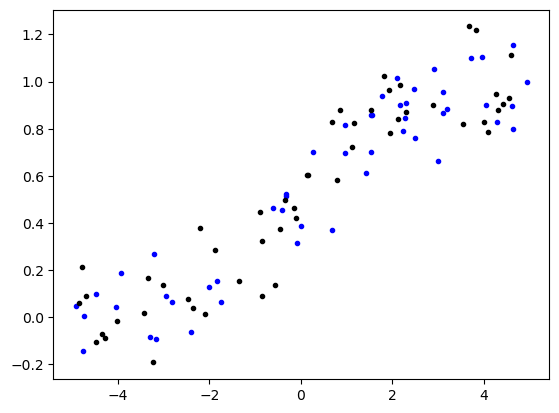

(50,)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

def f(X):
    return 1/(1 + np.exp(-X))

n = 50
np.random.seed(12345)
trainX = np.random.random(n) * 10 - 5
trainY = f(trainX) + np.random.randn(n) * 0.125
testX = np.random.random(n) * 10 - 5
testY = f(testX) + np.random.randn(n) * 0.125
plt.plot(trainX, trainY, 'b.', testX, testY, 'k.')
plt.show()
trainX.shape

#### Problem 1: Features (10 points)
For this problem, you need to create a Python function named `phi` that will produce a set of between 5 and 8 features for a given X input, such as the trainX vector created above.  This is basically what we did in lectures 5-7 to generate our design matrix $\Phi$.  The difference is that in our lectures we used powers of $x$ exclusively, where as below I would like you to use at least two non-polynomial functions of $x$.  You can use any functions you want; consider trigonometric functions, logarithmic and exponential functions, radial basis function (Gaussians), etc.  The only functions you are forbidden to use are functions generating a sigmoid such as the one generating the synthetic data for this problem (this includes the arctangent function)!  It is recommended, but not required, that one of your features is an intercept term (all 1's).

Note the triple-quoted string at the top of the function - this produces a documentation comment for the function (visible when you do help(function) or function?).  You should get in the habit of making these for your code.

Note: We discussed a variation of this in the `06-ml-beginnings lecture` ... your code will just have to create a list containing different functions of x to send into the np.array() instead of using all powers of x like we did for trainX in the example: `Phi = np.array([trainX ** p for p in range(6)]).T`

In [2]:
def phi(X):
    '''
    Return a design matrix (a NumPy ndarray) whose columns are functions of the input vector, X.
    '''
    return np.array([X**0, X**2, 2**X, (2*X)**2, 1 / 2*X]).T
    
    

You should probably check the output of phi(trainX) below, just to make sure none of your functions generated NaNs (Not a Number values) or infs (infinities) - these can result, e.g, from taking the log of a negative number or division by a number close to zero.

In [3]:
#calls your newly created phi function above for testing
Phi = phi(trainX)
Phi

array([[ 1.00000000e+00,  1.84569987e+01,  1.96459623e+01,
         7.38279949e+01,  2.14808046e+00],
       [ 1.00000000e+00,  3.37179370e+00,  2.80049847e-01,
         1.34871748e+01, -9.18122227e-01],
       [ 1.00000000e+00,  9.99073176e+00,  1.11815192e-01,
         3.99629270e+01, -1.58040594e+00],
       [ 1.00000000e+00,  8.72846290e+00,  1.29014291e-01,
         3.49138516e+01, -1.47719861e+00],
       [ 1.00000000e+00,  4.58667956e-01,  1.59908906e+00,
         1.83467183e+00,  3.38625145e-01],
       [ 1.00000000e+00,  9.12879027e-01,  1.93918041e+00,
         3.65151611e+00,  4.77723515e-01],
       [ 1.00000000e+00,  2.15773739e+01,  2.50223468e+01,
         8.63094956e+01,  2.32257260e+00],
       [ 1.00000000e+00,  2.34632230e+00,  2.89140554e+00,
         9.38528920e+00,  7.65885484e-01],
       [ 1.00000000e+00,  6.19545142e+00,  5.61414519e+00,
         2.47818057e+01,  1.24453319e+00],
       [ 1.00000000e+00,  2.35837052e+00,  2.89928812e+00,
         9.43348209e+00

#### Problem 2: Gradient Descent (20 points)
The basic idea behind [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is that you can minimize a parametrized function by simply taking small steps in the negative direction of the derivative of the function.  I'm not going to go into too many details here, since [Wikipedia's article](https://en.wikipedia.org/wiki/Gradient_descent) does such a good job.  Also see [Andrew Ng's class notes](https://datajobs.com/data-science-repo/Generalized-Linear-Models-[Andrew-Ng].pdf) on the topic for a more thorough mathematical treatment.

In our cases, we are interesting in minimizing the square error in our linear approximation with respect to our training data.  That is, we want to minimize
$$ \begin{align}
     & \sum_{i=0}^n (\hat{f}(x_i) - y_i)^2 \\
   = & \sum_{i=0}^n (\phi_0(x_i) w_0 + \phi_1(x_i) w_1 + \dots + \phi_k(x_i) w_k - y_i)^2 \\ 
   = & \|\Phi w - \textbf{y}\|^2 
   \end{align}
$$

Since all of our training data (the $x_i$ and $y_i$ terms) are known, the only variables we can optimize on are the $w$ variables. The gradient is (skipping over a *lot* of linear algebra):

$$ \begin{align}
       & \nabla \|\Phi w - \textbf{y}\|^2  \\
     = & \Phi^T (\Phi w - \textbf{y})
   \end{align}
$$

The gradient descent algorithm asks us, then, to start with some guess for $\textbf{w}$ and repeatedly subtract some small multiple of the gradient from it, until $\textbf{w}$ converges:

$$ \textbf{w} = \textbf{w} + \alpha \Phi^T (\textbf{y} - \Phi \textbf{w}) $$

Convergence is a somewhat tricky issue, and the step size $\alpha$ is a key to getting good convergence; a large $\alpha$ speeds up the algorithm, but can miss the optimum by stepping too far (and can even diverge); a small $\alpha$ may result in a better optimum, but at the cost of speed.  You may have to play around a bit with different values for $\alpha$ until you get a good result; print out the norm of the change in `w` at each step to see if you are converging or diverging, or put in an `if` statement to kill the function when the norm starts growing large.  In testing this assignment, I found I had to use a pretty small $\alpha$ to prevent divergence; 0.00001 worked for me.  However, you will get different results depending on your features.

So, you will write a function `lr` which takes in $\Phi$ (generated by your `phi` function above applied to `trainX`) and $y$ (`trainY`) and returns a vector `w` computed by gradient descent.  It is easiest to start `w` at the zero vector and go from there; as we already said, use $\alpha = 0.1$.  Stop training when the norm of the change in `w` is less than 1e-6 (the norm of a vector is the square root of the dot product of the vector with itself) or in any case after 100,000 steps have been taken.  Before returning, your function should print out the number of iterations (gradient descent steps) taken.

In [5]:
def lr(Phi, y):
    '''
    Computes a linear regression result w minimizing ||Phi w - y||^2 via gradient descent.
    '''
    w = np.array([0] * Phi.shape[1])

    a = 0.00001
    r=0
    norm = np.linalg.norm(r)
    steps = 0
    keepGoing = True

    # YOUR CODE HERE - FINISH THIS
    # Hint: calcuate the delta (starts at alpha in the equation), then add to w (e.g., w = w + delta)

    while keepGoing is True:
        
        # AxC
        # Magic Happens Here
        i = a * Phi.T
        j = y - (Phi @ w)
        r = i @ j
        w = w + r
        
        steps += 1
        
        if (np.linalg.norm(r) < 1e-16) or steps >= 1000000:
            keepGoing = False
            
    print("Number of Iterations: ", steps)

    return w


wTrain = lr(Phi, trainY)


Number of Iterations:  209433


#### Problem 3: Compute RMSE (10 points)
Use your `lr` function above to compute a solution, then using your solution, compute the RMSE of your result on both the training and the test data sets, and print them below. (For reference, I was able to achieve 0.11574 with 8 features.)

In [5]:
# YOUR CODE HERE - FINISH THIS
import math

diff = trainY - (Phi @ wTrain)

MSE = (diff ** 2).sum() / n
RMSE = math.sqrt(MSE)

print("trainMSE:  ", MSE)
print("trainRMSE: ", RMSE)

Phi2 = phi(testX)
wTest = lr(Phi2, testY)
diff2 = testY - (Phi2 @ wTest)

testMSE = (diff2 ** 2).sum() / n
testRMSE = math.sqrt(testMSE)

print("testMSE:  ", testMSE)
print("testRMSE: ", testRMSE)

trainMSE:   0.015887339474808894
trainRMSE:  0.12604498988380655
Number of Iterations:  46507
testMSE:   0.017829587751805008
testRMSE:  0.13352747938834542


#### Problem 4: Plot Results (10 points)
You are going to create three plots below. On the first plot, show the training and testing points (using markers of different colors), and a line plot of your learned function (compute $\hat{y}$ for $x \in (-5,5)$ at increments of 0.1).  This can be accomplished using `plt.plot(...)`, following the examples in the lectures.  Don't forget you can also look at the matplotlib documentation - there's a link under the Help menu in your notebook.  If you feel especially daring, you can try doing the plot in [bokeh](http://bokeh.pydata.org/) instead.

Your second and third plots should be of the residuals on the training set.  (The residuals are the errors, or differences between the training $y$ values and the corresponding $\hat{y}$ values.)  There are various ways to look at the residuals; for the second plot, use `plt.scatter(...)` (or bokeh equivalent) to plot the training $x$ values versus the residuals for the training $y$ values.  If the values are roughly equally distributed above and below the $x$ axis, then our approximation was probably pretty good.

The third plot should use `plt.hist(...)` (or bokeh equivalent) to show a histogram of the residuals (use 5 bins or so).  Given the small number of samples, it is unlikely you'll see a very normal distribution, but it should be vaguely normal, assuming we nearly approximated $f(x)$.

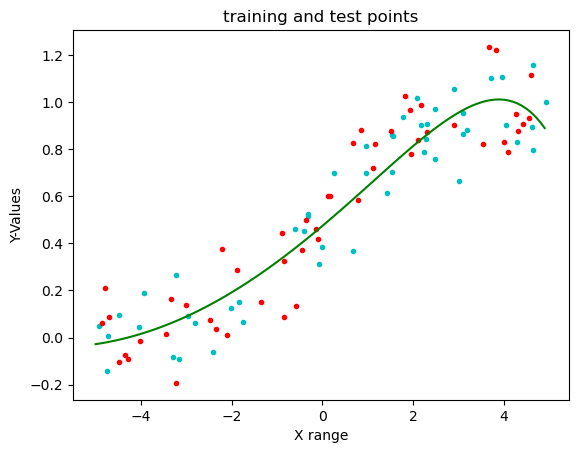

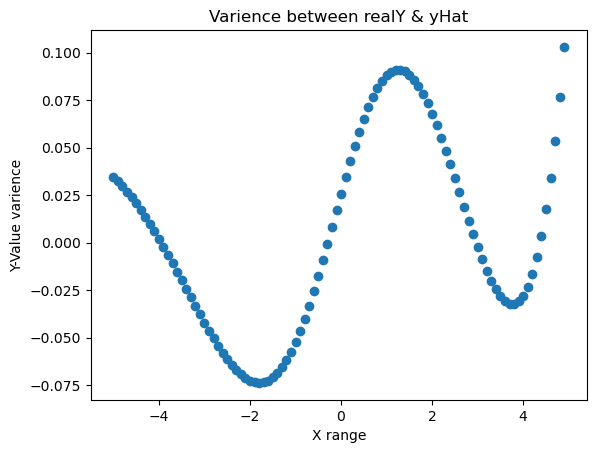

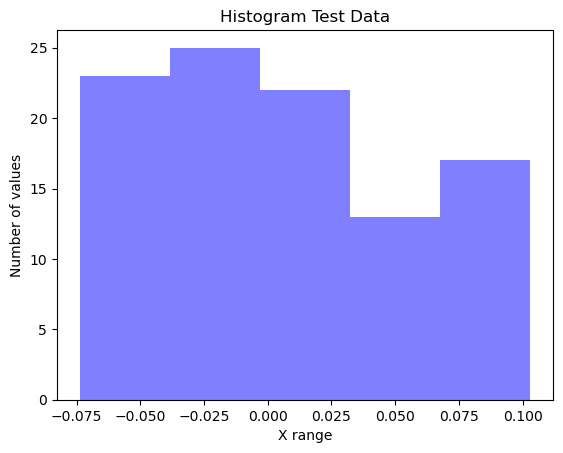

In [6]:
#hint, you will need something like this (feel free to change), to get the x∈(−5,5) at increments of 0.1
X = np.arange(-5,5,0.1)

# YOUR CODE HERE - FINISH THIS
yHat = phi(X) @ wTrain

plt.plot(trainX, trainY, 'c.', testX, testY, 'r.', X, yHat, 'g-')
plt.xlabel('X range')
plt.ylabel('Y-Values')
plt.title(r'training and test points')
plt.show()

realY = f(X)

residual =  realY - yHat
plt.scatter(X, residual)
plt.xlabel('X range')
plt.ylabel('Y-Value varience')
plt.title(r'Variance between realY & yHat')
plt.show()

plt.hist(residual, 5, facecolor='blue', alpha=0.5)
plt.xlabel('X range')
plt.ylabel('Number of values')
plt.title(r'Histogram Test Data')
plt.show()